| 表名 | 关键字段 | 合并方式 | 合并目的 / 特征说明 |
|------|----------|----------|------------------|
| new_house_transactions.csv | month, sector | 基础表，不合并 | 目标表，包含要预测的 `amount_new_house_transactions` |
| new_house_transactions_nearby_sectors.csv | month, sector | 左连接到 new_house_transactions 表 | 提供周边 sector 的新房交易特征（数量、面积、价格等） |
| pre_owned_house_transactions.csv | month, sector | 左连接到 new_house_transactions 表 | 提供本 sector 二手房交易特征（数量、面积、价格等） |
| pre_owned_house_transactions_nearby_sectors.csv | month, sector | 左连接到 new_house_transactions 表 | 提供周边 sector 二手房交易特征 |
| land_transactions.csv | month, sector | 左连接到 new_house_transactions 表 | 提供本 sector 土地交易特征（数量、建设面积、交易金额等） |
| land_transactions_nearby_sectors.csv | month, sector | 左连接到 new_house_transactions 表 | 提供周边 sector 土地交易特征 |
| sector_POI.csv | sector | 左连接到 new_house_transactions 表 | 提供 sector 静态特征（POI、人口、商业设施密度等） |
| city_search_index.csv | month | 聚合或按关键词左连接到 new_house_transactions 表 | 提供城市级搜索指数，可按月对 sector 共享 |
| city_indexes.csv | year | 将 year 转为 month，左连接到 new_house_transactions 表 | 提供城市年度宏观指标（GDP、人口、教育、医疗等） |

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pre_owned = pd.read_csv("train/pre_owned_house_transactions.csv")
pre_owned_nb = pd.read_csv("train/pre_owned_house_transactions_nearby_sectors.csv")

land = pd.read_csv("train/land_transactions.csv")
land_nb = pd.read_csv("train/land_transactions_nearby_sectors.csv")

new_house = pd.read_csv("train/new_house_transactions.csv")
new_house_nb = pd.read_csv("train/new_house_transactions_nearby_sectors.csv")

poi = pd.read_csv("train/sector_POI.csv")
search_index = pd.read_csv("train/city_search_index.csv")
city_idx = pd.read_csv("train/city_indexes.csv")

# ===== 统一清洗各类交易表（保证 month+sector 唯一、格式一致） =====

def clean_tx(df: pd.DataFrame, name: str) -> pd.DataFrame:
    df = df.copy()
    # 统一列名的小写
    df.columns = [c.strip() for c in df.columns]
    
    # 有的文件 month 列可能叫别的名字，这里假定是 'month' / 'Month'
    # 如果不是，请在这里手动改名：
    # df = df.rename(columns={'month_col_name_in_csv': 'month'})
    
    # 检查 (month, sector) 是否唯一
    dup_mask = df.duplicated(subset=['month', 'sector'], keep=False)
    if dup_mask.any():
        print(f"[{name}] 在 (month, sector) 上有 {dup_mask.sum()} 行重复，按数值列求和聚合。")
        num_cols = df.select_dtypes(include='number').columns
        df = df.groupby(['month', 'sector'], as_index=False)[num_cols].sum()
    else:
        print(f"[{name}] 在 (month, sector) 上没有重复。")
    
    return df

pre_owned   = clean_tx(pre_owned,   "pre_owned")
pre_owned_nb= clean_tx(pre_owned_nb,"pre_owned_nb")
land        = clean_tx(land,        "land")
land_nb     = clean_tx(land_nb,     "land_nb")
new_house   = clean_tx(new_house,   "new_house")
new_house_nb= clean_tx(new_house_nb,"new_house_nb")


[pre_owned] 在 (month, sector) 上没有重复。
[pre_owned_nb] 在 (month, sector) 上没有重复。
[land] 在 (month, sector) 上没有重复。
[land_nb] 在 (month, sector) 上没有重复。
[new_house] 在 (month, sector) 上没有重复。
[new_house_nb] 在 (month, sector) 上没有重复。


In [53]:
for df_name, df in zip(
    ['pre_owned', 'pre_owned_nb', 'land', 'land_nb', 'new_house', 'new_house_nb'],
    [pre_owned, pre_owned_nb, land, land_nb, new_house, new_house_nb]
):
    duplicates = df.duplicated(subset=['month', 'sector'], keep=False)
    print(df_name, duplicates.sum())

pre_owned 0
pre_owned_nb 0
land 0
land_nb 0
new_house 0
new_house_nb 0


In [54]:
# 构建完整的 (month, sector) 主键网格
all_pairs = pd.concat([
    pre_owned[['month','sector']],
    pre_owned_nb[['month','sector']],
    land[['month','sector']],
    land_nb[['month','sector']],
    new_house[['month','sector']],
    new_house_nb[['month','sector']]
]).drop_duplicates().reset_index(drop=True)
all_pairs.head()

,month,sector
0,2019-Jan,sector 35
1,2019-Jan,sector 23
2,2019-Jan,sector 80
3,2019-Jan,sector 53
4,2019-Jan,sector 84


In [55]:
# 加上target
master = all_pairs.merge(
    new_house[['month','sector','amount_new_house_transactions']],
    on=['month','sector'],
    how='left'
)
# # NAN值替换成0
# master['amount_new_house_transactions'] = master['amount_new_house_transactions'].fillna(0)
# master



# 暂时不要对目标做 fillna / ffill，这一步留到建模前再决定（删掉还是当 0）
print("master 中 amount_new_house_transactions 缺失行数：",
      master['amount_new_house_transactions'].isna().sum())




master 中 amount_new_house_transactions 缺失行数： 999


In [56]:
# 检查 master 的 month + sector 是否唯一
duplicates = master.duplicated(subset=['month', 'sector'], keep=False)
print("master 中重复的 month+sector 行数:", duplicates.sum())

master 中重复的 month+sector 行数: 0


In [57]:
# 合并其他数据表（左连接）

# 二手房
master = master.merge(pre_owned, on=['month', 'sector'], how='left', suffixes=('', '_pre'))
master = master.merge(pre_owned_nb, on=['month', 'sector'], how='left', suffixes=('', '_pre_nb'))
# 土地
master = master.merge(land, on=['month', 'sector'], how='left', suffixes=('', '_land'))
master = master.merge(land_nb, on=['month', 'sector'], how='left', suffixes=('', '_land_nb'))
# # 新房
master = master.merge(new_house, on=['month', 'sector'], how='left', suffixes=('', '_nh'))
master = master.merge(new_house_nb, on=['month', 'sector'], how='left', suffixes=('', '_nh_nb'))

master.shape


(6432, 37)

In [58]:
# 处理city_indexes
# 删除最后一行重复的 2022
city_idx = city_idx.drop(city_idx.index[-1])

missing_counts_city_idx = city_idx.isna().sum()
missing_counts_city_idx[missing_counts_city_idx > 0]

# ===== 清洗 city_indexes（宏观城市指标） =====

# 有的文件最后一行是重复的 2022，可以按你的观察删掉最后一行：
# 如果你确认不是这种情况，可以注释掉这一行
city_idx = city_idx.drop(city_idx.tail(1).index)

# 去重
city_idx = city_idx.drop_duplicates()

# 删除全 NaN 的列
city_idx = city_idx.loc[:, city_idx.notna().any(axis=0)]

# 看一下还有哪些列有缺失
missing_counts_city_idx = city_idx.isna().sum()
missing_counts_city_idx[missing_counts_city_idx > 0].sort_values(ascending=False)


total_fixed_assets_10k                              3
main_business_taxes_and_surcharges_10k              2
real_estate_development_investment_completed_10k    2
residential_development_investment_completed_10k    2
dtype: int64

In [59]:
# 删除所有存在缺失值的列
city_idx = city_idx.dropna(axis=1)
city_idx

,city_indicator_data_year,year_end_registered_population_10k,total_households_10k,year_end_resident_population_10k,year_end_total_employed_population_10k,year_end_urban_non_private_employees_10k,private_individual_and_other_employees_10k,private_individual_ratio,national_year_end_total_population_10k,resident_registered_ratio,...,road_area_10k_sqm,per_capita_urban_road_area_sqm,number_of_operating_bus_lines,operating_bus_line_length_km,internet_broadband_access_subscribers_10k,internet_broadband_access_ratio,number_of_industrial_enterprises_above_designated_size,total_current_assets_10k,science_expenditure_10k,education_expenditure_10k
0,2017,897.87,295.0211,1449.84,862.33,329.17,708.0004,0.821032,139008,1.614755,...,13012.82,10.98,14,398,521.52,0.580841,4664,96779199,1712569.0,4043335.0
1,2018,927.69,305.9851,1490.44,1102.36,348.65,753.7146,0.683728,139538,1.606614,...,18742.99,14.25,16,485,544.17,0.586586,4675,99067099,1636655.0,4408209.0
2,2019,953.72,313.8455,1530.59,1125.89,400.22,725.6720,0.644532,140005,1.604863,...,18792.69,12.46,15,523,565.83,0.593287,5804,110643480,2439456.0,5239743.0
3,2020,985.11,322.1068,1874.03,1158.01,419.36,738.6462,0.637858,141212,1.902356,...,19147.09,12.51,16,553,619.78,0.629148,6208,123664111,2241321.0,5585916.0
4,2021,1011.53,329.7224,1881.06,1163.44,426.94,736.5017,0.633038,141260,1.859619,...,22242.95,11.83,17,611,694.68,0.686762,6757,142064810,2012478.0,5890857.0


In [60]:
master.columns

Index(['month', 'sector', 'amount_new_house_transactions',
       'area_pre_owned_house_transactions',
       'amount_pre_owned_house_transactions',
       'num_pre_owned_house_transactions',
       'price_pre_owned_house_transactions',
       'num_pre_owned_house_transactions_nearby_sectors',
       'area_pre_owned_house_transactions_nearby_sectors',
       'amount_pre_owned_house_transactions_nearby_sectors',
       'price_pre_owned_house_transactions_nearby_sectors',
       'num_land_transactions', 'construction_area', 'planned_building_area',
       'transaction_amount', 'num_land_transactions_nearby_sectors',
       'construction_area_nearby_sectors',
       'planned_building_area_nearby_sectors',
       'transaction_amount_nearby_sectors', 'num_new_house_transactions',
       'area_new_house_transactions', 'price_new_house_transactions',
       'amount_new_house_transactions_nh',
       'area_per_unit_new_house_transactions',
       'total_price_per_unit_new_house_transactions',


In [61]:
# 删除重复行
master = master.drop_duplicates()

# 删除完全重复的列
master = master.loc[:, ~master.T.duplicated()]

master.shape

(6432, 36)

In [62]:
# 把 month 转成 datetime 类型（只保留年月）
master['month'] = pd.to_datetime(master['month'], format='%Y-%b')

# 把 sector 提取数字并转为 int
master['sector'] = master['sector'].str.extract(r'(\d+)').astype(int)

# 按 month 和 sector 排序
master = master.sort_values(['month', 'sector']).reset_index(drop=True)

master

# ===== master 添加 year 列，准备和 city_idx 合并 =====

# 这里假设 master['month'] 是类似 "2014-Jan" 的字符串
# 如果你的 month 列已经是 datetime，那就直接用 dt.year
master['year'] = pd.to_datetime(master['month'], format='%Y-%b').dt.year

# city_idx 也要有年份列，这里假设叫 'city_indicator_data_year'
# 如果你的文件里叫别的名字，请改成对应的列名
city_idx['city_indicator_data_year'] = city_idx['city_indicator_data_year'].astype(int)

# 合并宏观指标到 master：一年的指标复制到该年的每个月
master = master.merge(
    city_idx,
    left_on='year',
    right_on='city_indicator_data_year',
    how='left'
)

print("合并 city_idx 后 master 形状：", master.shape)


合并 city_idx 后 master 形状： (6432, 106)


In [63]:
missing_counts = master.isna().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
missing_counts

total_households_10k                           2976
year_end_resident_population_10k               2976
year_end_registered_population_10k             2976
city_indicator_data_year                       2976
year_end_total_employed_population_10k         2976
                                               ... 
total_price_per_unit_new_house_transactions     999
planned_building_area                           536
transaction_amount                              536
num_land_transactions                           536
construction_area                               536
Length: 103, dtype: int64

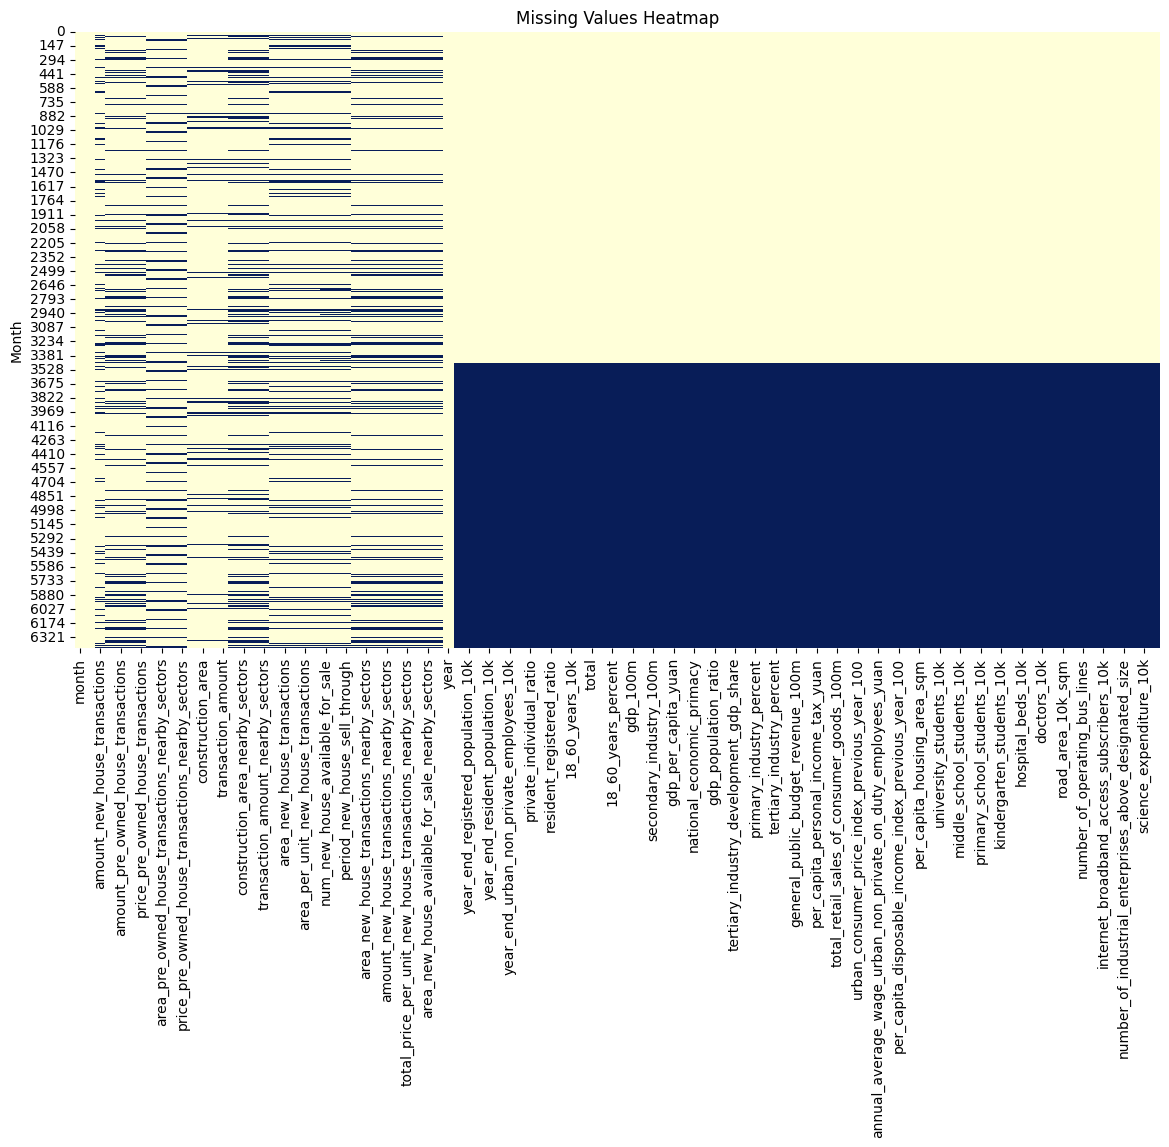

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
# 绘制缺失值热力图
plt.figure(figsize=(14, 8))
sns.heatmap(master.isna(), cbar=False, cmap="YlGnBu")
plt.ylabel("Month")
plt.title("Missing Values Heatmap")
plt.show()

In [65]:
# ===== 生成建模用的 df（从 master 出发） =====

df = master.copy()

# 统一 month 类型：转为 datetime 只保留年月
df['month'] = pd.to_datetime(df['month'], format='%Y-%b')

# sector 形如 "sector 1" 的话，提取数字；如果已经是整数可以跳过这一步
if df['sector'].dtype == 'object':
    df['sector'] = df['sector'].str.extract(r'(\d+)').astype(int)

# 再检查一次 (month, sector) 是否唯一
dup_mask = df.duplicated(subset=['month', 'sector'], keep=False)
print("df 中 (month, sector) 重复行数：", dup_mask.sum())

# 删除完全相同的重复行
df = df.drop_duplicates()

# 删除完全相同的重复列
df = df.loc[:, ~df.T.duplicated()]

print("去重后的 df 形状：", df.shape)

df.head()


df 中 (month, sector) 重复行数： 0
去重后的 df 形状： (6432, 105)


,month,sector,amount_new_house_transactions,area_pre_owned_house_transactions,amount_pre_owned_house_transactions,num_pre_owned_house_transactions,price_pre_owned_house_transactions,num_pre_owned_house_transactions_nearby_sectors,area_pre_owned_house_transactions_nearby_sectors,amount_pre_owned_house_transactions_nearby_sectors,...,road_area_10k_sqm,per_capita_urban_road_area_sqm,number_of_operating_bus_lines,operating_bus_line_length_km,internet_broadband_access_subscribers_10k,internet_broadband_access_ratio,number_of_industrial_enterprises_above_designated_size,total_current_assets_10k,science_expenditure_10k,education_expenditure_10k
0,2019-01-01,1,13827.14,9163.0,40994.7,111.0,44739.38666,6.750000,733.000000,1247.03800,...,18792.69,12.46,15.0,523.0,565.83,0.593287,5804.0,110643480.0,2439456.0,5239743.0
1,2019-01-01,2,28277.73,192.0,315.0,2.0,16406.25000,64.181818,5339.000000,20880.24282,...,18792.69,12.46,15.0,523.0,565.83,0.593287,5804.0,110643480.0,2439456.0,5239743.0
2,2019-01-01,3,NaN,NaN,NaN,NaN,NaN,77.714286,7457.142857,17376.21486,...,18792.69,12.46,15.0,523.0,565.83,0.593287,5804.0,110643480.0,2439456.0,5239743.0
3,2019-01-01,4,1424.21,0.0,0.0,0.0,12794.68999,57.666667,5109.666667,19021.15267,...,18792.69,12.46,15.0,523.0,565.83,0.593287,5804.0,110643480.0,2439456.0,5239743.0
4,2019-01-01,5,792.10,NaN,NaN,NaN,NaN,45.428571,3763.500000,15800.74143,...,18792.69,12.46,15.0,523.0,565.83,0.593287,5804.0,110643480.0,2439456.0,5239743.0


In [66]:
# ===== 缺失值概览 =====
missing_counts = df.isna().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
missing_counts


total_households_10k                           2976
year_end_resident_population_10k               2976
city_indicator_data_year                       2976
year_end_registered_population_10k             2976
retail_sales_growth_rate                       2976
                                               ... 
total_price_per_unit_new_house_transactions     999
transaction_amount                              536
planned_building_area                           536
construction_area                               536
num_land_transactions                           536
Length: 102, dtype: int64

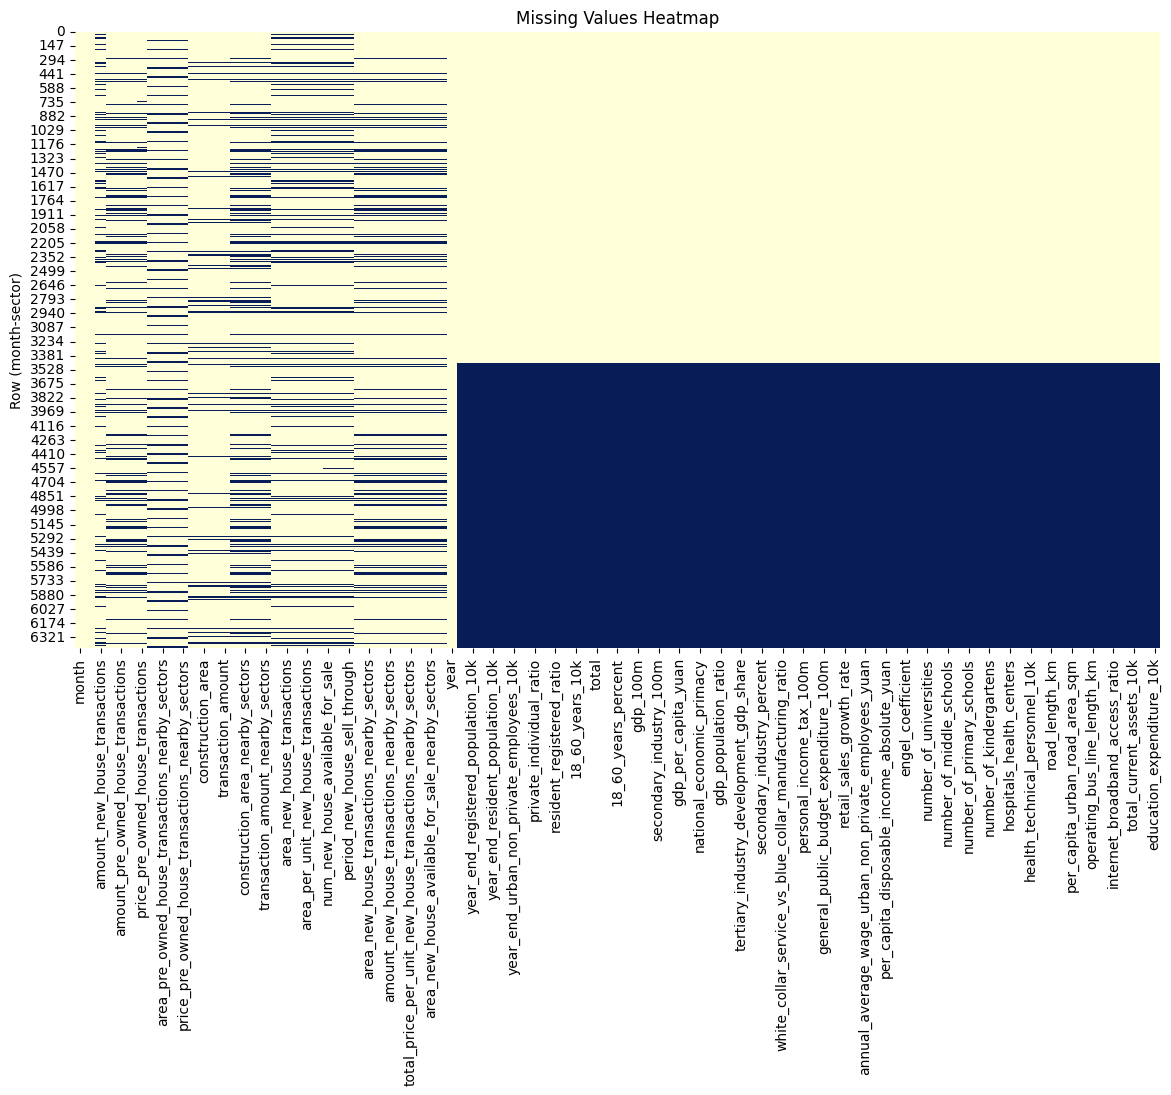

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
# 注意：月 × 特征的矩阵，多了会很大，这里只是粗略看一下
sns.heatmap(df.isna(), cbar=False, cmap="YlGnBu")
plt.ylabel("Row (month-sector)")
plt.title("Missing Values Heatmap")
plt.show()


In [ ]:
# ===== 按列类型做缺失值处理（不动目标列） =====

target_col = "amount_new_house_transactions"

# 1. 宏观时间序列类特征：来自 city_idx / search_index
macro_cols = [c for c in df.columns 
              if c.startswith("city_") or c.startswith("search_")]

# 2. 计数/金额类特征：num_ / amount_ / area_ 等（除目标以外）
count_cols = [c for c in df.columns 
              if (("num_" in c) or ("amount_" in c) or ("area_" in c))]
count_cols = [c for c in count_cols if c != target_col]

# 3. 其他数值特征
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
other_num_cols = [c for c in num_cols_all 
                  if c not in macro_cols + count_cols + [target_col]]

# ---- 1) 宏观特征：按 sector+时间排序后做 ffill+bfill ----
# ---- 1) 宏观特征：按 sector+时间排序后做 ffill+bfill ----
df = df.sort_values(["sector", "month"])
if macro_cols:
    # 方法1：使用 transform
    for col in macro_cols:
        df[col] = df.groupby("sector")[col].transform(
            lambda x: x.ffill().bfill()
        )
    
    # 方法2：或者直接在原DataFrame上操作
    # df[macro_cols] = df.groupby("sector")[macro_cols].transform(
    #     lambda x: x.ffill().bfill()
    # )

# ---- 2) 计数/金额类：缺失多半表示“当月没有发生”，可默认填 0（不含目标） ----
if count_cols:
    df[count_cols] = df[count_cols].fillna(0)

# ---- 3) 剩余数值特征：用中位数填补 ----
if other_num_cols:
    df[other_num_cols] = df[other_num_cols].fillna(df[other_num_cols].median())

# 4) 目标列暂时不动，留给后面建模时决定是：删除这些样本，还是部分当 0
df[target_col].isna().sum(), df.shape


TypeError: incompatible index of inserted column with frame index